In [301]:
import numpy as np
from mvlearn.embed import GCCA
from mvlearn.datasets import sample_joint_factor_model
from graspy.plot import pairplot
from scipy.sparse.linalg import svds

import sys; sys.path.append('../')
from src.tools import iterate_align, align
from scipy.stats import ortho_group

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2 subjects, 2 states each (4 views total). Each view the sum of a subject matrix (dominant), state matrix, and noise

In [9]:
n = 10
trait_1 = np.random.normal(0, 1, (n, 2))
svals_1 = np.asarray([12, 10])
state_11 = np.random.normal(0, 1, (n, 2))
svals_11 = np.asarray([8, 7])
state_12 = np.random.normal(0, 1, (n, 2))
svals_12 = np.asarray([8, 7])


trait_2 = np.random.normal(0, 1, (n, 2))
svals_2 = np.asarray([12, 10])
state_21 = np.random.normal(0, 1, (n, 2))
svals_21 = np.asarray([8, 7])
state_22 = np.random.normal(0, 1, (n, 2))
svals_22 = np.asarray([8, 7])

X1 = trait_1 @ np.diag(svals_1) @ trait_1.T + state_11 @ np.diag(svals_11) @ state_11.T + np.random.normal(0,1,(n,n))
X2 = trait_1 @ np.diag(svals_1) @ trait_1.T + state_12 @ np.diag(svals_12) @ state_12.T + np.random.normal(0,1,(n,n))

X3 = trait_2 @ np.diag(svals_2) @ trait_2.T + state_21 @ np.diag(svals_21) @ state_21.T + np.random.normal(0,1,(n,n))
X4 = trait_2 @ np.diag(svals_2) @ trait_2.T + state_22 @ np.diag(svals_22) @ state_22.T + np.random.normal(0,1,(n,n))

In [10]:
Xs = [X1, X2, X3, X4]

In [94]:
n = 10
m = 15
noise_std = 0.01
n_subjs = 4
Xs = np.concatenate([sample_joint_factor_model(2, n, m, joint_rank=2, m=1, noise_std=noise_std) for _ in range(n_subjs)])
Xs += np.concatenate([sample_joint_factor_model(1, n, m, joint_rank=2, m=1, noise_std=noise_std) for _ in range(len(Xs))])

In [95]:
gcca = GCCA(n_components=4)
Xs_gcca = gcca.fit_transform(Xs)

In [96]:
mv_svds = []
for X in Xs:
    u, s, v = svds(X, k=4)
    idx = np.argsort(s)[::-1]
    u = u[:, idx]
    s = s[idx]
    mv_svds.append(u @ np.diag(s))

In [97]:
Xs_svds = iterate_align(mv_svds)

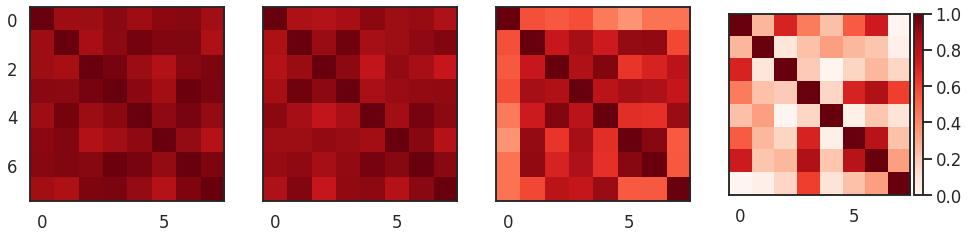

In [98]:
f, axs = plt.subplots(1, 4, figsize=(16,4), sharey=True)

for i in range(4):
    ax = axs[i]
    im = ax.imshow(np.corrcoef(Xs_gcca[:,:,i]), vmin=0, vmax=1, cmap='Reds')

    if i == 3:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

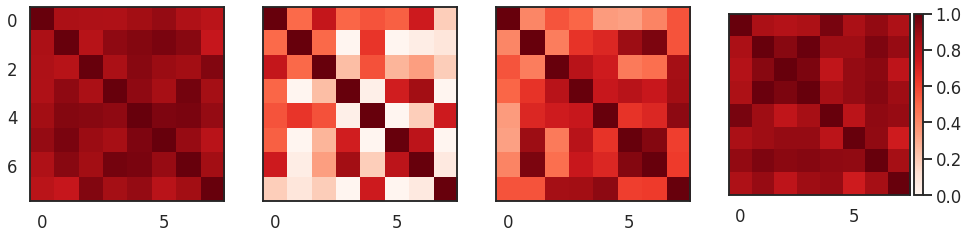

In [99]:
f, axs = plt.subplots(1, 4, figsize=(16,4), sharey=True)

for i in range(4):
    ax = axs[i]
    im = ax.imshow(np.corrcoef(Xs_svds[:,:,i]), vmin=0, vmax=1, cmap='Reds')

    if i == 3:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

## Test align process

In [533]:
from collections import defaultdict

def iterate_align(components, labels, subjs, thresh=0.001, max_iter=10, norm=False, mean_align=False, debug=False):
    if norm:
        embeddings = components /  np.linalg.norm(components, axis=1, keepdims=True)
    else:
        embeddings = components

    if max_iter <= 0:
        return embeddings

    if mean_align:
        assert subjs is not None
        objs = []
        subj_embeddings = defaultdict(list)
        for embedding, subj, l in zip(embeddings, subjs, labels):
            subj_embeddings[subj].append((embedding, l))

        subj_ids = []
        subj_means = []
        subj_mats = []
        subj_labels = []
        for subj, embs_ls in subj_embeddings.items():
            embs, ls = list(zip(*embs_ls))
            subj_ids.append(subj)
            subj_labels.append(ls)
            embs, obj = _iterate_align(embs, thresh, max_iter)
            objs.append(obj)
            subj_mats.append(embs)
            subj_means.append(np.mean(embs, axis=0))
        objs = np.hstack(objs)

        aligned_means, embeddings, obj = _iterate_align(subj_means, thresh, max_iter, aux_mats=subj_mats, debug=debug)
        objs = np.vstack((objs, obj))
        embeddings = np.vstack(embeddings)
        labels = np.vstack(subj_labels)
        subjs = np.hstack([[id]*3 for id in subj_ids])
    else:
        embeddings, objs = _iterate_align(embeddings, thresh, max_iter, debug=debug)

    return embeddings, labels, subjs, objs

def _iterate_align(embeddings, thresh, max_iter, aux_mats=None, debug=False):
    objs = []
    n = embeddings[0].shape[1]
    if aux_mats is not None:
        embeddings, aux_mats = align(embeddings[1:], embeddings[0], firstpass=True, aux_mats=aux_mats)
    else:
        embeddings = align(embeddings[1:], embeddings[0], firstpass=True)
    prior_embed = None
    for i in range(max_iter):
        mean = np.mean(embeddings, axis=0).squeeze()
        if aux_mats is not None:
            embeddings, aux_mats = align(
                embeddings, np.asarray(mean),
                firstpass = False, aux_mats=aux_mats)
            # objs.append([np.trace(mean.T @ embed) / n for embed in np.vstack(aux_mats)])
            objs.append([np.linalg.norm(mean - embed) / n for embed in np.vstack(aux_mats)])
        else:
            embeddings = align(
                embeddings, np.asarray(mean),
                firstpass=False, debug=True)
            # objs.append([np.trace(mean.T @ embed) / n for embed in embeddings])
            objs.append([np.linalg.norm(mean - embed) / n for embed in embeddings])
        embeddings = np.asarray(embeddings)
        if debug and prior_embed is not None:
            print(np.linalg.norm(embeddings - prior_embed))
        if prior_embed is not None and np.linalg.norm(embeddings - prior_embed) < thresh:
            break
        prior_embed = embeddings

    if aux_mats is not None:
        return embeddings, aux_mats, objs
    else:
        return embeddings, objs

## Case 1, 2 subjects w/ 2 scans each
- subject 1: nx2 basis, each scan an orthogonal rotation 
- subject 2: nx3 basis, each scan an orthogonal projection to nx2

In [557]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2']
subjs = [1, 1, 2, 2]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis = ortho_group.rvs(25)
    Xs = [basis[:,:2] @ ortho_group.rvs(2) for _ in range(2)]
    Xs += [basis[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.trace(embs[i].T @ embs[j] / embs.shape[1]) for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.trace(embs[i].T @ embs[j] / embs.shape[1]) for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

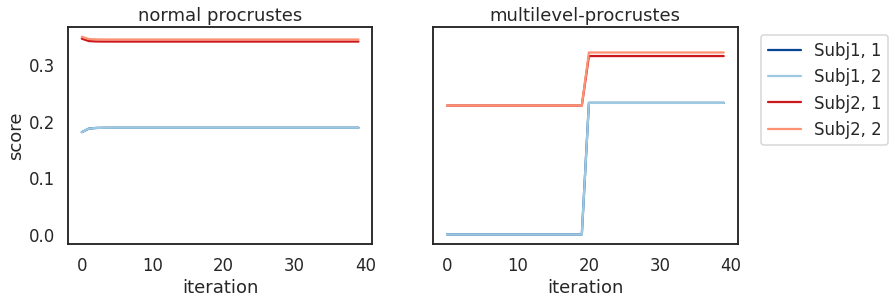

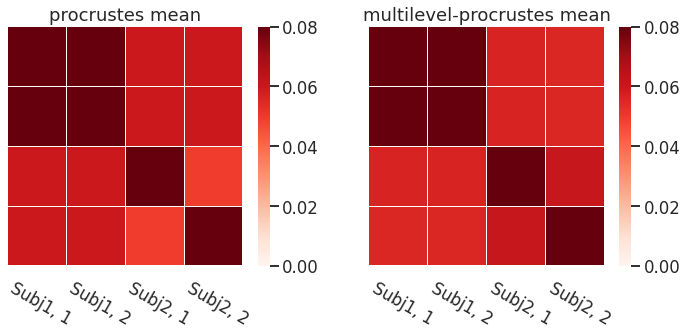

In [558]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = y + objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    # ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1)

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('score')

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = y + objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    # ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1)
    
ax.set_title('multilevel-procrustes')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10,5))
ax = axs[0]
ax = sns.heatmap(
    trace_normal_means, cmap='Reds', vmax=np.max(trace_normal_means), vmin=0, linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')


ax = axs[1]
im = sns.heatmap(
    trace_means, cmap='Reds', vmax=np.max(trace_means), vmin=0, linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

# im = ax.imshow(trace_std, cmap='Reds', vmax=np.max(trace_std), vmin=0)
# ax.set_title('std')
# ax.set_yticklabels([])
# ax.set_xticks([0,1,2,3])
# ax.set_xticklabels(labels, rotation=-30, ha='left')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

## Case 2: 3 subjects w/ 2 scans each
- each subject: nx3 basis orthogonal projected to nx2

In [590]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis = ortho_group.rvs(25)
    Xs = [basis[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,3:6] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,6:9] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

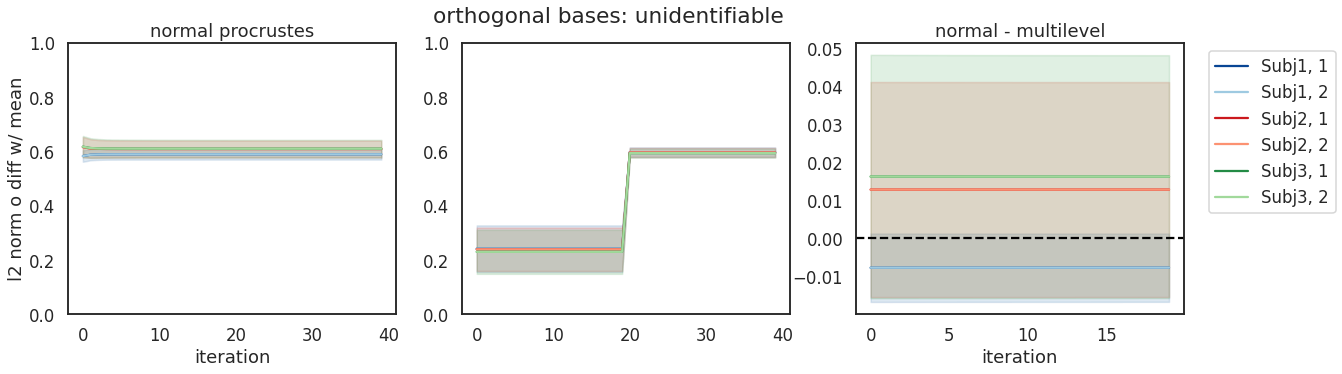

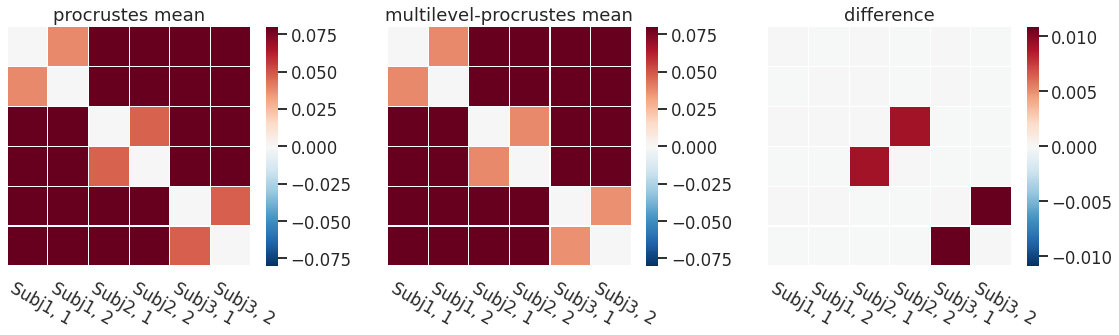

In [592]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('orthogonal bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('difference')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

# im = ax.imshow(trace_std, cmap='Reds', vmax=np.max(trace_std), vmin=0)
# ax.set_title('std')
# ax.set_yticklabels([])
# ax.set_xticks([0,1,2,3])
# ax.set_xticklabels(labels, rotation=-30, ha='left')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

In [588]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis = ortho_group.rvs(25)
    Xs = [basis[:,np.asarray([0,1,2])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,np.asarray([0,3,4])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,np.asarray([0,5,6])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

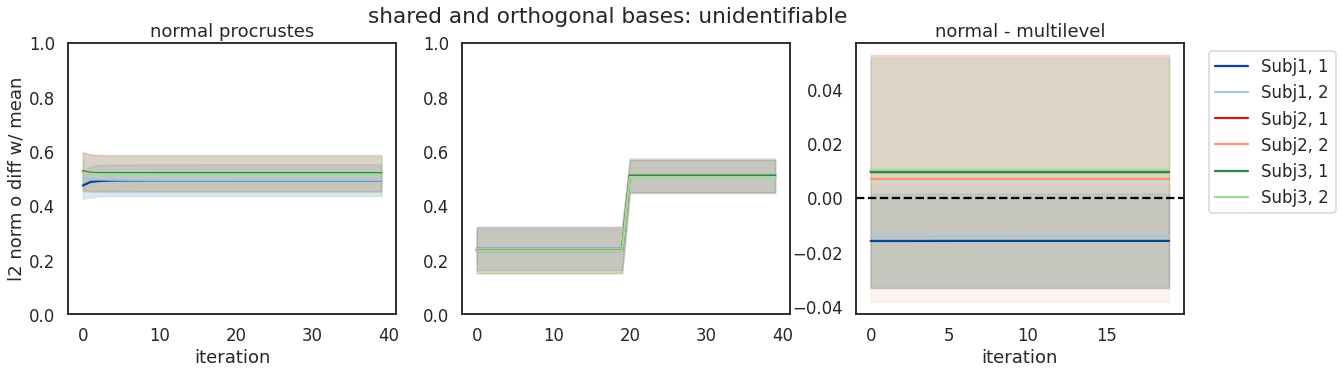

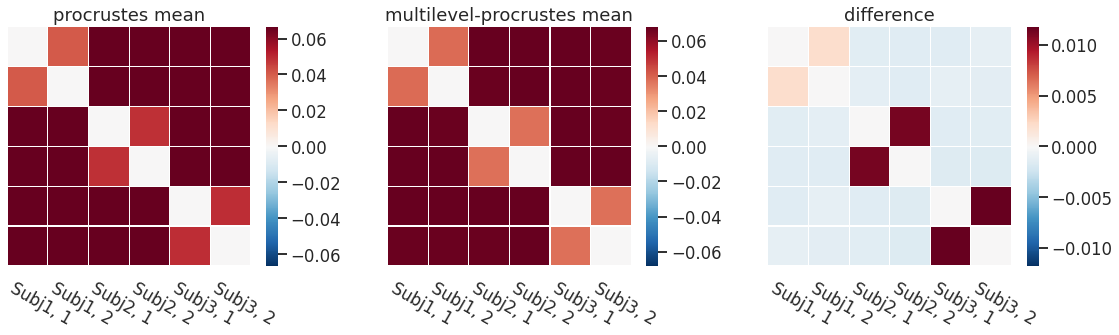

In [589]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('shared and orthogonal bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('difference')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

In [586]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis1 = ortho_group.rvs(25)
    basis2 = ortho_group.rvs(25)
    basis3 = ortho_group.rvs(25)
    Xs = [basis1[:,:3] @ ortho_group.rvs(3)[:,:3] for _ in range(2)]
    Xs += [basis2[:,:3] @ ortho_group.rvs(3)[:,:3] for _ in range(2)]
    Xs += [basis3[:,:3] @ ortho_group.rvs(3)[:,:3] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

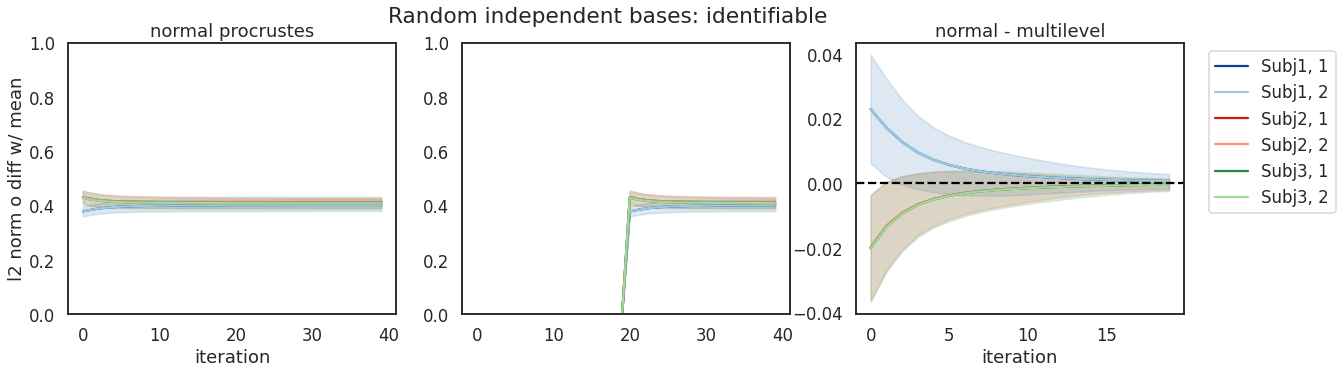

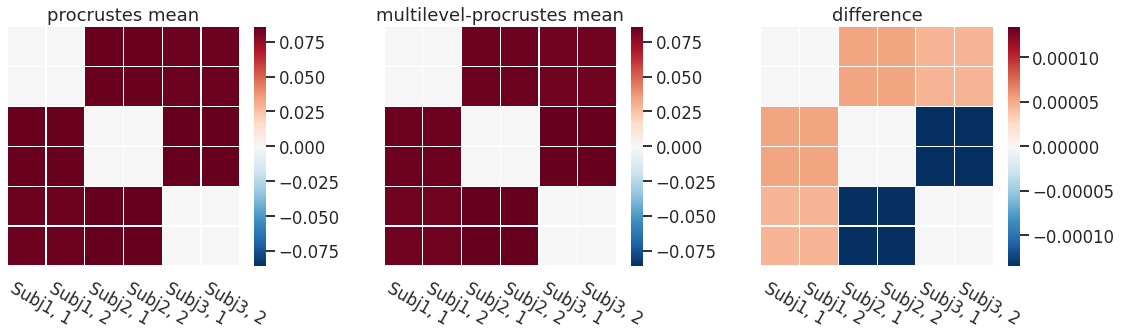

In [587]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Random independent bases: identifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('difference')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

In [583]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis1 = ortho_group.rvs(25)
    basis2 = ortho_group.rvs(25)
    basis3 = ortho_group.rvs(25)
    Xs = [basis1[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis2[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis3[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

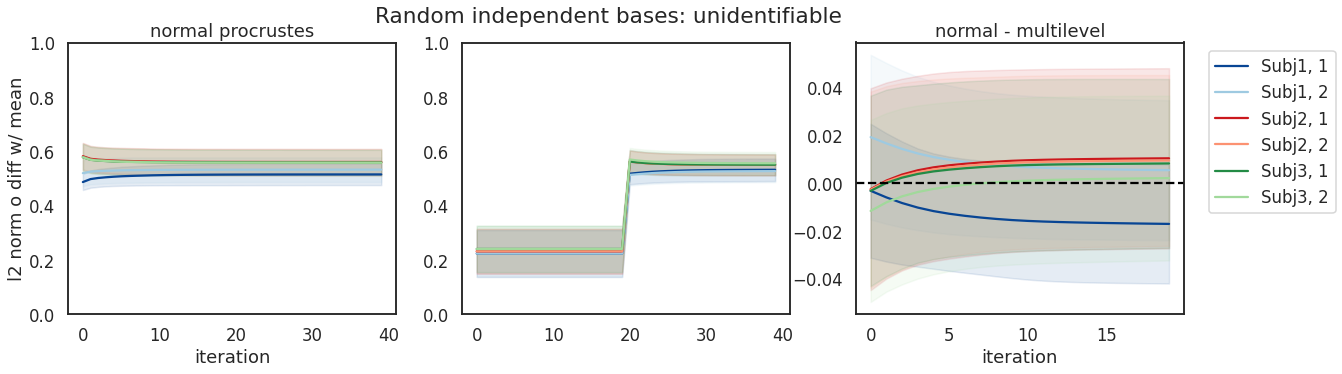

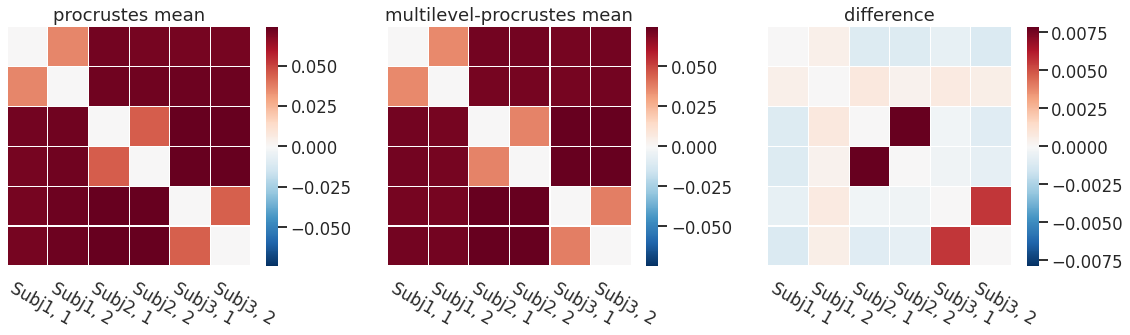

In [585]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Random independent bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('difference')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()